# Test Model

In [1]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent))

from settings.global_settings import GlobalSettings

config = GlobalSettings.get_config(
    config_file = "../config.ini",
    secrets_file = "../secrets.ini"
)
from dataset.video_loader import VideoDataLoader
from dataset.video_dataset import VideoDataset, default_augmentation_pipeline
from model.training_loop import train, EarlyStoppingParams
from model.multimodal_har_model import MultiModalHARModel

Loading config...
Loading secrets...


2025-12-11 00:31:06,032 - INFO - Sentry DSN set to: https://f4f21cc936b3ba9f5dbc1464b7a40ea4@o4504168838070272.ingest.us.sentry.io/4506464560414720
2025-12-11 00:31:06,033 - INFO - Sentry initialized with environment: development


In [2]:
OBSERVATION_RATIO = 20
EAR_RATIO = OBSERVATION_RATIO / 100
WITH_OBJECT_BRANCH = False

MODEL_PATH = "/Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_100_with_obj_20251207_145531.pht"

## Initializing Training

**Creating Dataloaders**

In [3]:
TRAIN_DIR = os.path.join(
    config.model_settings.video_data_dir,
    "train"
)
TEST_DIR = os.path.join(
    config.model_settings.video_data_dir,
    "test"
)


train_video_data_loader = VideoDataLoader(
    path=TRAIN_DIR,
)
test_video_data_loader = VideoDataLoader(
    path=TEST_DIR,
)


train_dataset = VideoDataset(
    video_data_loader=train_video_data_loader,
    normalization_type="across_frames",
    EAR_ratio=EAR_RATIO,
    # transform=default_augmentation_pipeline(target_len=16, noise_std=0.02),
)
test_dataset = VideoDataset(
    video_data_loader=test_video_data_loader,
    normalization_type="across_frames",
    EAR_ratio=EAR_RATIO,
)


len(train_dataset)
for _ in train_dataset:
    pass
len(train_dataset.labels_map)

len(test_dataset)
for _ in test_dataset:
    pass


display(len(test_dataset.labels_map))
display(len(train_dataset.labels_map))

2025-12-11 00:31:08,421 - INFO - [VideoDataLoader] Loding action videos for action: 0_safe_walkway_violation
2025-12-11 00:31:09,053 - INFO - [VideoDataLoader] Loding action videos for action: 1_unauthorized_intervention
2025-12-11 00:31:09,441 - INFO - [VideoDataLoader] Loding action videos for action: 2_opened_panel cover
2025-12-11 00:31:09,865 - INFO - [VideoDataLoader] Loding action videos for action: 3_carrying_overload_with_forklift
2025-12-11 00:31:09,983 - INFO - [VideoDataLoader] Loding action videos for action: 4_safe_walkway
2025-12-11 00:31:10,119 - INFO - [VideoDataLoader] Loding action videos for action: 5_authorized_intervention
2025-12-11 00:31:10,321 - INFO - [VideoDataLoader] Loding action videos for action: 6_closed_panel_cover
2025-12-11 00:31:10,361 - INFO - [VideoDataLoader] Loding action videos for action: 7_safe_carrying
2025-12-11 00:31:10,818 - INFO - [VideoDataLoader] Loding action videos for action: 0_safe_walkway_violation
2025-12-11 00:31:10,921 - INFO - 

8

8

**Loading Model**

In [4]:

har_model, _ = MultiModalHARModel.load(MODEL_PATH)

2025-12-11 00:31:11,494 - INFO - Loading model from /Volumes/KODAK/masters/model/validation_datasets/UNSAFE-NET/model/har_model_v1.0.1_unsafe_net_100_with_obj_20251207_145531.pht...
2025-12-11 00:31:11,800 - INFO - Model config: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-11 00:31:11,801 - INFO - Model configuration: {'obj_in': 5, 'joint_in': 3, 'gat_hidden': 192, 'gat_out': 192, 'temporal_hidden': 192, 'num_classes': 8, 'dropout': 0.1, 'temporal_pooling': 'attn_pool', 'use_layer_norm': True, 'attention_pooling_heads': 4, 'temporal_transformer_heads': 4, 'use_object_branch': True, 'device': 'cpu'}
2025-12-11 00:31:11,863 - INFO - ✅ Model loaded and ready for inference


## Debugging

In [5]:
import torch, torch.nn.functional as F
device = 'cpu'   # match training device
har_model.to(device)
har_model.eval()

sample = train_dataset[0]
graphs_objects = [g.to(device) for g in sample.graphs_objects]
graphs_joints = [g.to(device) for g in sample.graphs_joints]
label = sample.label.unsqueeze(0).to(device)

with torch.no_grad():
    out = har_model(graphs_objects, graphs_joints)   # expect [1, num_classes]
    probs = F.softmax(out, dim=-1)
    ent = -(probs * probs.log()).sum(dim=-1)     # entropy
    pred = torch.argmax(probs, dim=-1)

print("out.shape", out.shape)
print("out device", out.device, "label device", label.device)
print("logits:", out.cpu().numpy())
print("probs:", probs.cpu().numpy())
print("entropy:", ent.item())
print("pred:", pred.item(), "label:", label.item())


out.shape torch.Size([1, 8])
out device cpu label device cpu
logits: [[-1.6517699  -1.3327129   1.4932688  -1.3749031  -1.134077   -0.63733685
   0.8384375  -1.600155  ]]
probs: [[0.02248804 0.03093971 0.522185   0.0296615  0.03773833 0.06201748
  0.27129063 0.02367923]]
entropy: 1.3751542568206787
pred: 2 label: 0


**Mapping Consistency - Distribution**

In [6]:
from collections import Counter
def inspect_dataset(dataset, name):
    labels = [int(s.label) for s in dataset]
    print(f"=== {name} ===")
    print("len:", len(labels))
    print("unique labels:", sorted(set(labels)))
    print("counts:", Counter(labels))
    print("labels_map (sample):", getattr(dataset, "labels_map", None))
    print()

inspect_dataset(train_dataset, "TRAIN")
inspect_dataset(test_dataset, "TEST")


=== TRAIN ===
len: 566
unique labels: [0, 1, 2, 3, 4, 5, 6, 7]
counts: Counter({0: 178, 2: 129, 1: 97, 4: 50, 3: 48, 5: 23, 7: 22, 6: 19})
labels_map (sample): {'0_safe_walkway_violation': 0, '1_unauthorized_intervention': 1, '2_opened_panel cover': 2, '3_carrying_overload_with_forklift': 3, '4_safe_walkway': 4, '5_authorized_intervention': 5, '6_closed_panel_cover': 6, '7_safe_carrying': 7}

=== TEST ===
len: 125
unique labels: [0, 1, 2, 3, 4, 5, 6, 7]
counts: Counter({0: 32, 4: 25, 5: 15, 2: 13, 6: 13, 1: 11, 3: 8, 7: 8})
labels_map (sample): {'0_safe_walkway_violation': 0, '1_unauthorized_intervention': 1, '2_opened_panel cover': 2, '3_carrying_overload_with_forklift': 3, '4_safe_walkway': 4, '5_authorized_intervention': 5, '6_closed_panel_cover': 6, '7_safe_carrying': 7}



**Prediction Distribution - Predicts only few classes**

In [7]:
from collections import Counter
import torch, torch.nn.functional as F

def pred_distribution(model, dataset, device='cpu'):
    model.eval()
    preds = []
    truths = []
    with torch.no_grad():
        for s in dataset:
            graphs_objects = [g.to(device) for g in s.graphs_objects]
            graphs_joints  = [g.to(device) for g in s.graphs_joints]
            out = model(graphs_objects, graphs_joints)  # [1, C]
            preds.append(int(torch.argmax(out, dim=-1)))
            truths.append(int(s.label))
    print("pred distribution:", Counter(preds))
    print("true distribution :", Counter(truths))
    return preds, truths

preds, truths = pred_distribution(har_model, test_dataset, device='cpu')


pred distribution: Counter({2: 44, 6: 34, 7: 15, 3: 12, 0: 12, 4: 4, 5: 3, 1: 1})
true distribution : Counter({0: 32, 4: 25, 5: 15, 2: 13, 6: 13, 1: 11, 3: 8, 7: 8})


**Confusion Matrix - Per Class Prediction**

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(truths, preds)
print("Confusion matrix:\n", cm)
print(classification_report(truths, preds, digits=4))


Confusion matrix:
 [[ 6  0 10  5  3  1  7  0]
 [ 2  0  5  1  0  1  2  0]
 [ 0  0  5  0  0  0  7  1]
 [ 0  0  1  3  0  0  1  3]
 [ 4  1  9  2  1  0  7  1]
 [ 0  0 11  0  0  1  3  0]
 [ 0  0  3  0  0  0  6  4]
 [ 0  0  0  1  0  0  1  6]]
              precision    recall  f1-score   support

           0     0.5000    0.1875    0.2727        32
           1     0.0000    0.0000    0.0000        11
           2     0.1136    0.3846    0.1754        13
           3     0.2500    0.3750    0.3000         8
           4     0.2500    0.0400    0.0690        25
           5     0.3333    0.0667    0.1111        15
           6     0.1765    0.4615    0.2553        13
           7     0.4000    0.7500    0.5217         8

    accuracy                         0.2240       125
   macro avg     0.2529    0.2832    0.2132       125
weighted avg     0.2898    0.2240    0.1943       125



**Confusion Matrix**

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, class_names, normalize=True, figsize=(10, 8), cmap="Blues"):
    """
    Visual, attractive confusion matrix with optional normalization.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)  # handle div-by-zero

    plt.figure(figsize=figsize)
    sns.set(font_scale=1.2)
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap=cmap,
        square=True,
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        annot_kws={"size": 12, "weight": "bold"}
    )

    plt.title("Confusion Matrix", fontsize=18, weight="bold")
    plt.ylabel("True Label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

    plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45, ha="right")
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)

    plt.tight_layout()
    plt.show()


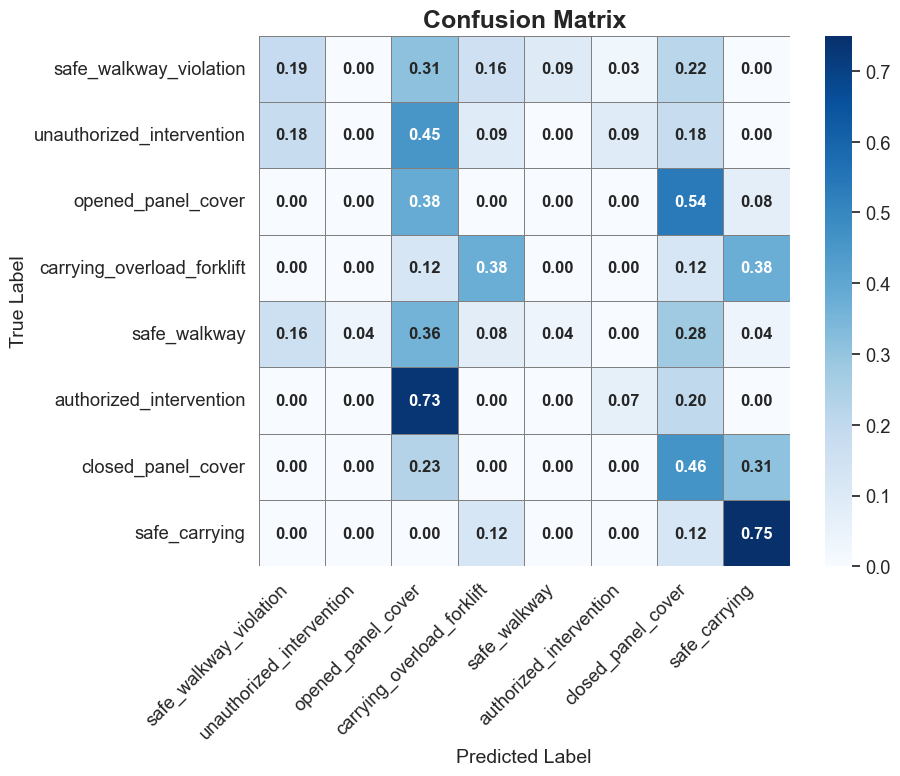

In [10]:
class_names = [
    "safe_walkway_violation",
    "unauthorized_intervention",
    "opened_panel_cover",
    "carrying_overload_forklift",
    "safe_walkway",
    "authorized_intervention",
    "closed_panel_cover",
    "safe_carrying"
]

plot_confusion_matrix(cm, class_names, normalize=True)
